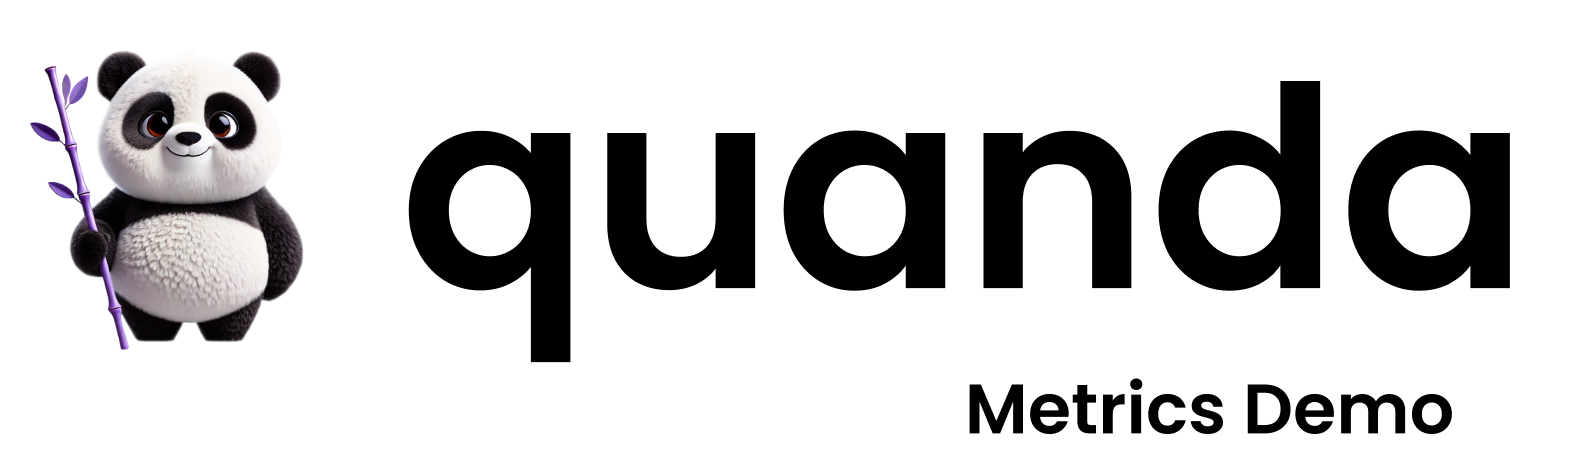

In this notebook, we show you how to use quanda for data attribution evaluation.

Throughout this tutorial we will be using a toy [ResNet18](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html) models trained on [Tiny ImageNet](http://vision.stanford.edu/teaching/cs231n/reports/2015/pdfs/yle_project.pdf). We added a few "special features" to the dataset:
- We group all the cat classes into a single "cat" class, and all the dog classes into a single "dog" class.
- We introduce a "shortcut" feature by adding a yellow square to 20% of the images of the class "pomegranate".
- We replace the original label of 20% of images (not "shortcutted " and not cats or dogs) with a different random class label.
- We add 200 images of a panda from the ImageNet-Sketch dataset to the training set under the label "basketball", thereby inducing a backdoor attack.

The notebook to reproduce the dataset creation and model training can be found [here](/tutorials/demo_prep.ipynb).
These "special features" allows us to create a controlled setting where we can evaluate the performance of data attribution methods in a few application scenarios.


## Load Data and Model

In [1]:
import os
import random
import subprocess

import torch
import torchvision.transforms as transforms
import lightning as L
from PIL import Image
from torch.utils.data import Subset

from quanda.metrics.downstream_eval import (
    ClassDetectionMetric,
    MislabelingDetectionMetric,
    SubclassDetectionMetric,
    ShortcutDetectionMetric
)
from quanda.metrics.heuristics import ModelRandomizationMetric, TopKOverlapMetric, MixedDatasetsMetric
from quanda.utils.datasets.transformed import (
    LabelGroupingDataset,
    TransformedDataset,
)
from tutorials.utils.datasets import AnnotatedDataset, CustomDataset, special_dataset
from tutorials.utils.modules import LitModel

In [2]:
torch.set_float32_matmul_precision("medium")

In [3]:
tiny_in_path = "/data1/datapool"
panda_sketch_path = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/sketch/"
save_dir = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/"

n_epochs = 10
checkpoints = [os.path.join(save_dir, f"tiny_imagenet_resnet18_epoch={epoch:02d}.ckpt") for epoch in range(5, n_epochs, 1)]

In [4]:
random_rng = random.Random(27)

### Downloading the datasets and checkpoints

In [5]:
# We first download the datasets (uncomment the following cell if you haven't downloaded the datasets yet).:
os.makedirs(save_dir, exist_ok=True)

# subprocess.run(["wget", "-P", tiny_in_path, "http://cs231n.stanford.edu/tiny-imagenet-200.zip"])
# subprocess.run(["unzip", os.path.join(tiny_in_path, "tiny-imagenet-200.zip"), "-d", tiny_in_path])
# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/FpPWkzPmM3s9ZqF/download/sketch.zip"])
# subprocess.run(["unzip", os.path.join(save_dir, "sketch.zip"), "-d", save_dir])

In [6]:
# Next we download all the necessary checkpoints and the dataset metadata (uncomment the following cell if you haven't downloaded the checkpoints yet).:

# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/ZE5dBnfzW94Xkoo/download/tiny_inet_resnet18.zip"])
# subprocess.run(["unzip", "-j", os.path.join(save_dir, "tiny_inet_resnet18.zip"), "-d", save_dir])
# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/AmnCXAC8zx3YQgP/download/dataset_indices.zip"])
# subprocess.run(["unzip", "-j", os.path.join(save_dir, "dataset_indices.zip"), "-d", save_dir])

### Dataset Construction

In [7]:
# Loading the dataset metadata
class_to_group = torch.load(os.path.join(save_dir, "class_to_group.pth"))
r_name_dict = torch.load(os.path.join(save_dir, "r_name_dict.pth"))
test_indices = torch.load(os.path.join(save_dir, "main_test_indices.pth"))
test_split = torch.load(os.path.join(save_dir, "test_indices.pth"))
val_split = torch.load(os.path.join(save_dir, "val_indices.pth"))
panda_train_indices = torch.load(os.path.join(save_dir, "panda_train_indices.pth"))
panda_val_indices = torch.load(os.path.join(save_dir, "panda_val_indices.pth"))
panda_test_indices = torch.load(os.path.join(save_dir, "panda_test_indices.pth"))

In [8]:
n_classes = 200
new_n_classes = len(set(list(class_to_group.values())))
batch_size = 64
num_workers = 1
device = "cuda:0"

In [9]:
# Define transformations
regular_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

denormalize = transforms.Compose(
    [transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225])]
    + [transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])]
)

In [10]:
# Load the TinyImageNet dataset
with open(tiny_in_path + "/tiny-imagenet-200/wnids.txt", "r") as f:
    id_dict = {line.strip(): i for i, line in enumerate(f)}

with open(tiny_in_path + "/tiny-imagenet-200/val/val_annotations.txt", "r") as f:
    val_annotations = {line.split("\t")[0]: line.split("\t")[1] for line in f}

train_set_raw = CustomDataset(tiny_in_path + "/tiny-imagenet-200/train", classes=list(id_dict.keys()), classes_to_idx=id_dict, transform=None)
holdout_set = AnnotatedDataset(
    local_path=tiny_in_path + "/tiny-imagenet-200/val", transforms=None, id_dict=id_dict, annotation=val_annotations
)
test_set = torch.utils.data.Subset(holdout_set, test_split)

In [11]:
backdoor_transforms = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

panda_dataset = CustomDataset(
    panda_sketch_path, classes=["n02510455"], classes_to_idx={"n02510455": 5}, transform=backdoor_transforms
)

panda_set = torch.utils.data.Subset(panda_dataset, panda_train_indices)
panda_rest = torch.utils.data.Subset(panda_dataset, [i for i in range(len(panda_dataset)) if i not in panda_train_indices])
panda_test = torch.utils.data.Subset(panda_rest, panda_test_indices)

In [12]:
def add_yellow_square(img):
    square_size = (15, 15)  # Size of the square
    yellow_square = Image.new("RGB", square_size, (255, 255, 0))  # Create a yellow square
    img.paste(yellow_square, (10, 10))  # Paste it onto the image at the specified position
    return img

In [13]:
train_set = special_dataset(
    train_set_raw,
    n_classes,
    new_n_classes,
    regular_transforms,
    class_to_group=class_to_group,
    shortcut_fn=add_yellow_square,
    backdoor_dataset=panda_set,
    shortcut_transform_indices=torch.load(os.path.join(save_dir, "all_train_shortcut_indices_for_generation.pth")),
    flipping_transform_dict=torch.load(os.path.join(save_dir, "all_train_flipped_dict_for_generation.pth")),
)

test_set_grouped = LabelGroupingDataset(
    dataset=test_set,
    n_classes=n_classes,
    dataset_transform=regular_transforms,
    class_to_group=class_to_group,
)

test_set_ungrouped = TransformedDataset(
    dataset=test_set,
    n_classes=200,
    dataset_transform=regular_transforms,
)

### Defining Test Samples

In [14]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### Load Model

In [15]:
lit_model = LitModel.load_from_checkpoint(
    checkpoints[-1], n_batches=len(train_dataloader), num_labels=new_n_classes, map_location=torch.device("cuda:0")
)
lit_model.eval()

LitModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [16]:
def load_state_dict(module: L.LightningModule, path: str) -> int:
    checkpoints = torch.load(path, map_location=torch.device("cuda:0"))
    module.model.load_state_dict(checkpoints["model_state_dict"])
    module.eval()
    return module.lr

## Define the Explainer

### Representer Point Selector

Utilizes the [implementation](https://github.com/chihkuanyeh/Representer_Point_Selection) provided by the original authors of the [Representer Point Selection paper](https://proceedings.neurips.cc/paper_files/paper/2018/file/8a7129b8f3edd95b7d969dfc2c8e9d9d-Paper.pdf) to determine training data attribution for predictions on test samples.

In [17]:
from quanda.explainers.wrappers import RepresenterPoints

# Initialize Explainer
model_id = "test_model"
cache_dir = "tmp_repr"

explain_kwargs = {
    "load_from_disk": True,
    "show_progress": False,
    "features_layer": "model.avgpool",
    "classifier_layer": "model.fc",
    "batch_size": 32,
    "features_postprocess": lambda x: x[:, :, 0, 0],
    "model_id": model_id,
    "cache_dir": cache_dir,
}

explainer_repr = RepresenterPoints(
    model=lit_model,
    train_dataset=train_dataloader.dataset,
    **explain_kwargs,
)

2024-09-27 12:14:34,437 - quanda.explainers.wrappers.representer_points - INFO - Initializing Representer Point Selection explainer...
/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/torch/__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)
/home/bareeva/Projects/data_attribution_evaluation/quanda/explainers/wrappers/representer_points.py:118: UserWarning: This method is only a good idea for small datasets and small architectures. Otherwise, this will consume a lot of memory.
  warnings.warn(


## Evaluation Metrics

### Model Randomization Metric

In [18]:
clean_samples = torch.load(os.path.join(save_dir, "big_eval_test_clean_indices.pth"))
clean_dataset = torch.utils.data.Subset(test_set_grouped, clean_samples)
dataloader = torch.utils.data.DataLoader(
    clean_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

In [19]:
model_rand = ModelRandomizationMetric(
    model=lit_model,
    train_dataset=train_set,
    explainer_cls=RepresenterPoints,
    expl_kwargs=explain_kwargs,
    correlation_fn="spearman",
    seed=42,
)

2024-09-27 12:15:17,357 - quanda.explainers.wrappers.representer_points - INFO - Initializing Representer Point Selection explainer...


In [20]:
for i, (test_tensor, test_labels) in enumerate(dataloader):
    test_tensor, test_labels = test_tensor.to(device), test_labels.to(device)
    explanation_targets = lit_model.model(test_tensor.to(device)).argmax(dim=1)
    explanations_repr = explainer_repr.explain(test_tensor, explanation_targets)
    model_rand.update(test_tensor, explanations_repr, explanation_targets)

In [21]:
score = model_rand.compute()
print("Model randomization metric output:", score)

Model randomization metric output: {'score': 0.12738032639026642}


### Class Detection Metric

In [22]:
id_class = ClassDetectionMetric(model=lit_model, train_dataset=train_set)

In [23]:
for i, (test_tensor, test_labels) in enumerate(dataloader):
    test_tensor, test_labels = test_tensor.to(device), test_labels.to(device)
    explanation_targets = lit_model.model(test_tensor.to(device)).argmax(dim=1)
    explanations_repr = explainer_repr.explain(test_tensor, explanation_targets)
    id_class.update(test_labels, explanations_repr)

In [24]:
score = id_class.compute()
print("Identical class metric output:", score)

Identical class metric output: {'score': 0.546875}


### Subclass Detection Metric

In [25]:
test_dogs = torch.load(os.path.join(save_dir, "big_eval_test_dogs_indices.pth"))
test_cats = torch.load(os.path.join(save_dir, "big_eval_test_cats_indices.pth"))

cat_dog_dataset = torch.utils.data.Subset(test_set_grouped, test_cats + test_dogs)
subclass_dataloader = torch.utils.data.DataLoader(
    cat_dog_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

train_subclass = torch.tensor([5 for s in panda_set] + [s[1] for s in train_set_raw])
test_subclass = torch.tensor([test_set_ungrouped[i][1] for i in (test_cats + test_dogs)])

In [26]:
id_subclass = SubclassDetectionMetric(model=lit_model, train_dataset=train_set, train_subclass_labels=train_subclass)

In [27]:
for i, (test_tensor, test_labels) in enumerate(subclass_dataloader):
    test_tensor, test_labels = test_tensor.to(device), test_labels.to(device)
    explanation_targets = lit_model.model(test_tensor.to(device)).argmax(dim=1)
    explanations_repr = explainer_repr.explain(test_tensor, explanation_targets)
    id_subclass.update(test_subclass[i: (i+1)*subclass_dataloader.batch_size],explanations_repr)                

In [28]:
score = id_subclass.compute()
print("Subclass detection metric output:", score)

Subclass detection metric output: {'score': 0.1875}


### Top-k Overlap Metric

In [29]:
dataloaders_top_k_overlap = dataloader

In [30]:
top_k = TopKOverlapMetric(model=lit_model, train_dataset=train_set, top_k=1)

In [31]:
for i, (test_tensor, test_labels) in enumerate(dataloader):
    test_tensor, test_labels = test_tensor.to(device), test_labels.to(device)
    explanation_targets = lit_model.model(test_tensor.to(device)).argmax(dim=1)
    explanations_repr = explainer_repr.explain(test_tensor, explanation_targets)
    top_k.update(explanations_repr.to(device))

In [32]:
score = top_k.compute()
print("Top-k overlap metric output:", score)

Top-k overlap metric output: {'score': 0.90625}


### Mislabeling Detection Metric

In [33]:
mislabeled = MislabelingDetectionMetric(
    model=lit_model,
    train_dataset=train_set,
    mislabeling_indices=torch.load(os.path.join(save_dir, "all_train_flipped_indices.pth")),
    global_method="self-influence",
    model_id=model_id,
    cache_dir=cache_dir,
    explainer_cls=RepresenterPoints,
    expl_kwargs=explain_kwargs,
)

2024-09-27 12:16:11,564 - quanda.explainers.wrappers.representer_points - INFO - Initializing Representer Point Selection explainer...


In [34]:
score = mislabeled.compute()
print("Mislabeling detection metric output:", score["score"])

Mislabeling detection metric output: 0.6147637963294983


### Mixed Datasets Metric

In [35]:
dataloaders_mixed = torch.utils.data.DataLoader(
    panda_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

In [36]:
all_adv_indices = torch.load(os.path.join(save_dir, "all_train_backdoor_indices.pth"))
# to binary
adv_indices = torch.tensor([1 if i in all_adv_indices else 0 for i in range(len(train_set))])
        
mixed_dataset = MixedDatasetsMetric(
    train_dataset=train_set,
    model=lit_model,
    adversarial_indices=adv_indices,
    filter_by_prediction=True,
)

In [37]:
for i, (test_tensor, test_labels) in enumerate(dataloaders_mixed):
    test_tensor, test_labels = test_tensor.to(device), test_labels.to(device)
    explanation_targets = lit_model.model(test_tensor.to(device)).argmax(dim=1)
    explanations_repr = explainer_repr.explain(test_tensor, explanation_targets)
    mixed_dataset.update(explanations_repr.to(device), test_tensor.to(device), test_labels.to(device))

In [42]:
score = mixed_dataset.compute()
print("Mixed datasets metric output:", score)

Mixed datasets metric output: {'score': 0.4306114614009857}


### Shortcut Detection Metric

In [38]:
# find regular samples
test_shortcut = torch.load(os.path.join(save_dir, "big_eval_test_shortcut_indices.pth"))

shortcut_dataset = TransformedDataset(
    dataset=torch.utils.data.Subset(test_set, test_shortcut),
    n_classes=new_n_classes,
    dataset_transform=regular_transforms,
    transform_indices=list(range(len(test_shortcut))),
    sample_fn=add_yellow_square,
    label_fn=lambda x: class_to_group[x],
)
dataloaders_shortcut = torch.utils.data.DataLoader(
    shortcut_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

In [39]:
shortcut = ShortcutDetectionMetric(
    model=lit_model,
    train_dataset=train_set,
    shortcut_indices=torch.load(os.path.join(save_dir, "all_train_shortcut_indices.pth")),
    shortcut_cls=162,
    filter_by_prediction=False,
    filter_by_class=False,
)

In [40]:
for i, (test_tensor, test_labels) in enumerate(dataloaders_shortcut):
    test_tensor, test_labels = test_tensor.to(device), test_labels.to(device)
    explanation_targets = lit_model.model(test_tensor.to(device)).argmax(dim=1)
    explanations_repr = explainer_repr.explain(test_tensor, explanation_targets)
    shortcut.update(explanations_repr.to(device))

In [41]:
score = shortcut.compute()
print("Shortcut detection metric output:", score)

Shortcut detection metric output: {'score': 0.11949198693037033}
